# XG Boost

Original shape: (2154048, 19)
Inactive churn dropped: 299279
Shape after cleaning: (1854769, 19)
Shape after drop useless: (1854769, 16)
[TOP_PACK] Rare packs merged: 58
[PACK_GROUP] Final groups:
PACK_GROUP
NO_PACK         603324
VOICE_ALLNET    384957
DATA_PACK       360442
VOICE_ONNET     321942
COMBO_PACK       67512
SOCIAL_PACK      66874
DAILY_PACK       45228
OTHER_PACK        3115
WIFI_PACK          651
RARE_PACK          432
EVC_PACK           139
WEEKLY_PACK         85
MONTHLY_PACK        68
Name: count, dtype: int64

Training XGBoost...
Training done.

===== BEST THRESHOLD FOR XGBOOST =====
Threshold: 0.8490635451505016
Best F1 (churn): 0.5190055901597277

=== XGBOOST CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.96    350013
           1       0.43      0.64      0.52     20941

    accuracy                           0.93    370954
   macro avg       0.71      0.80      0.74    370954
weighted avg  

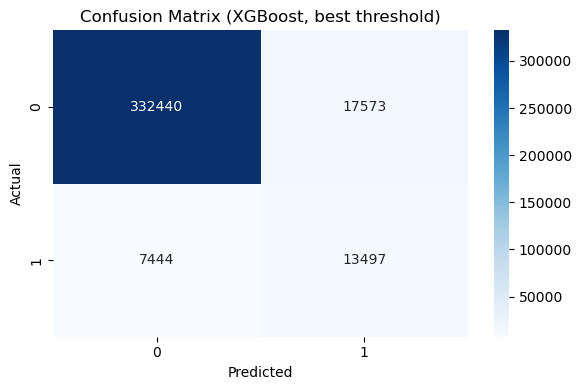

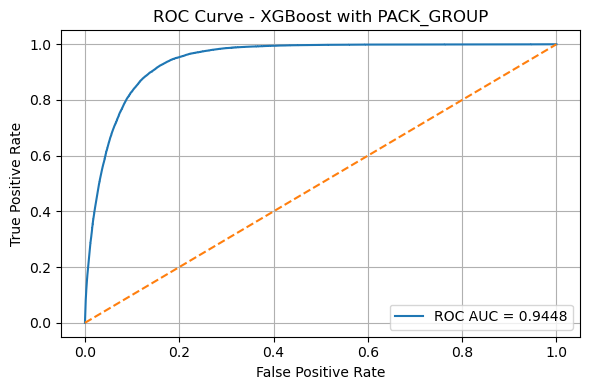

In [1]:
# =============================================================================
# 0. IMPORT
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

import xgboost as xgb

pd.set_option('display.float_format', '{:.3f}'.format)


# =============================================================================
# 1. FUNCTION: CLEAN + STANDARDIZE TOP_PACK
# =============================================================================
def prepare_top_pack(
    df,
    col_name="TOP_PACK",
    rare_threshold=50,
    new_clean_col="TOP_PACK_CLEAN",
    new_group_col="PACK_GROUP"
):
    """Clean + standardize TOP_PACK into PACK_GROUP."""

    df[col_name] = df[col_name].fillna("no_pack")
    top_pack_str = df[col_name].astype(str).str.strip()
    df[new_clean_col] = top_pack_str.copy()

    # 1. Rare handling for TOP_PACK
    pack_counts = df[new_clean_col].value_counts()
    rare_packs = pack_counts[pack_counts < rare_threshold].index
    df[new_clean_col] = df[new_clean_col].where(
        ~df[new_clean_col].isin(rare_packs),
        "RARE_PACK"
    )

    print(f"[TOP_PACK] Rare packs merged: {len(rare_packs)}")

    # 2. Grouping → PACK_GROUP
    def pack_group(x):
        s = str(x).lower()

        if s == "no_pack":
            return "NO_PACK"
        if "rare_pack" in s:
            return "RARE_PACK"
        if any(k in s for k in ["data:", "gprs", "mifi", "internet"]):
            return "DATA_PACK"
        if "wifi" in s:
            return "WIFI_PACK"
        if any(k in s for k in ["on net", "on-net", "onnet"]):
            return "VOICE_ONNET"
        if any(k in s for k in ["all-net", "all net", "allnet"]):
            return "VOICE_ALLNET"
        if any(k in s for k in ["mixt", "mix ", "combo"]):
            return "COMBO_PACK"
        if any(k in s for k in ["jokko", "ymgx", "youth", "facebook", "fb ", "twter", "twitter", "social"]):
            return "SOCIAL_PACK"
        if any(k in s for k in ["24h", "1day", "1 day", "daily", "one day"]):
            return "DAILY_PACK"
        if any(k in s for k in ["weekly", "7d", "7 d", "week"]):
            return "WEEKLY_PACK"
        if any(k in s for k in ["monthly", "30d", "30 d", "month"]):
            return "MONTHLY_PACK"
        if "evc_" in s:
            return "EVC_PACK"
        if any(k in s for k in ["fifa", "sport"]):
            return "SPORT_PACK"
        if any(k in s for k in ["vas(", "ivr", "radio", "crbt", "telmun"]):
            return "VAS_PACK"

        return "OTHER_PACK"

    df[new_group_col] = df[new_clean_col].apply(pack_group)

    # Rare PACK_GROUP
    group_counts = df[new_group_col].value_counts()
    rare_groups = group_counts[group_counts < 50].index
    df[new_group_col] = df[new_group_col].where(
        ~df[new_group_col].isin(rare_groups),
        "OTHER_PACK"
    )

    print("[PACK_GROUP] Final groups:")
    print(df[new_group_col].value_counts())

    return df


# =============================================================================
# 2. LOAD DATA
# =============================================================================
df = pd.read_csv("./dataset/Train.csv")
print("Original shape:", df.shape)


# =============================================================================
# 3. DROP INACTIVE CHURN
# =============================================================================
usage_cols = ["MONTANT", "REVENUE", "ON_NET", "ORANGE", "TIGO", "ZONE1", "ZONE2"]
usage_sum = df[usage_cols].fillna(0).sum(axis=1)

inactive_mask = (usage_sum == 0) & (df["CHURN"] == 1)
print("Inactive churn dropped:", inactive_mask.sum())

df = df[~inactive_mask].copy()
print("Shape after cleaning:", df.shape)


# =============================================================================
# 4. DROP USELESS COLUMNS
# =============================================================================
drop_cols = [c for c in ["ARPU_SEGMENT", "MRG", "user_id"] if c in df.columns]
df = df.drop(columns=drop_cols)
print("Shape after drop useless:", df.shape)


# =============================================================================
# 5. HANDLE MISSING VALUES
# =============================================================================
df["REGION"] = df["REGION"].fillna("unknown")

extra_numeric_cols = ["FREQUENCE_RECH", "FREQUENCE", "DATA_VOLUME", "FREQ_TOP_PACK"]
for col in usage_cols + extra_numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)


# =============================================================================
# 6. CLEAN TOP_PACK INTO PACK_GROUP
# =============================================================================
df = prepare_top_pack(df)


# =============================================================================
# 7. SAFE FLOAT → INT
# =============================================================================
def convert_float(df_):
    for col in df_.select_dtypes(include="float").columns:
        if (df_[col].dropna() == np.floor(df_[col].dropna())).all():
            df_[col] = df_[col].astype("Int64")
    return df_

df = convert_float(df)


# =============================================================================
# 8. LABEL ENCODING
# =============================================================================
label_cols = ["REGION", "TENURE", "PACK_GROUP"]
for col in label_cols:
    le = LabelEncoder()
    df[col + "_enc"] = le.fit_transform(df[col].astype(str))

df = df.drop(columns=label_cols + ["TOP_PACK", "TOP_PACK_CLEAN"])


# =============================================================================
# 9. TRAIN/TEST SPLIT
# =============================================================================
# Drop rows where 'CHURN' is NaN
df.dropna(subset=["CHURN"], inplace=True)

X = df.drop("CHURN", axis=1)
y = df["CHURN"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# =============================================================================
# 10. TRAIN XGBOOST MODEL
# =============================================================================
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    learning_rate=0.05,
    n_estimators=800,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"   # GPU dùng: "gpu_hist"
)

print("\nTraining XGBoost...")
xgb_model.fit(X_train, y_train)
print("Training done.")


# =============================================================================
# 11. THRESHOLD OPTIMIZATION (maximize F1)
# =============================================================================
y_prob = xgb_model.predict_proba(X_test)[:, 1]

best_th = 0.5
best_f1 = 0.0

for t in np.linspace(0.01, 0.99, 300):
    y_temp = (y_prob >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_temp).ravel()
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)

    if f1 > best_f1:
        best_f1 = f1
        best_th = t

print("\n===== BEST THRESHOLD FOR XGBOOST =====")
print("Threshold:", best_th)
print("Best F1 (churn):", best_f1)


# =============================================================================
# 12. FINAL EVAL
# =============================================================================
y_pred = (y_prob >= best_th).astype(int)

print("\n=== XGBOOST CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", auc)


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (XGBoost, best threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost with PACK_GROUP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== FEATURE IMPORTANCE ===


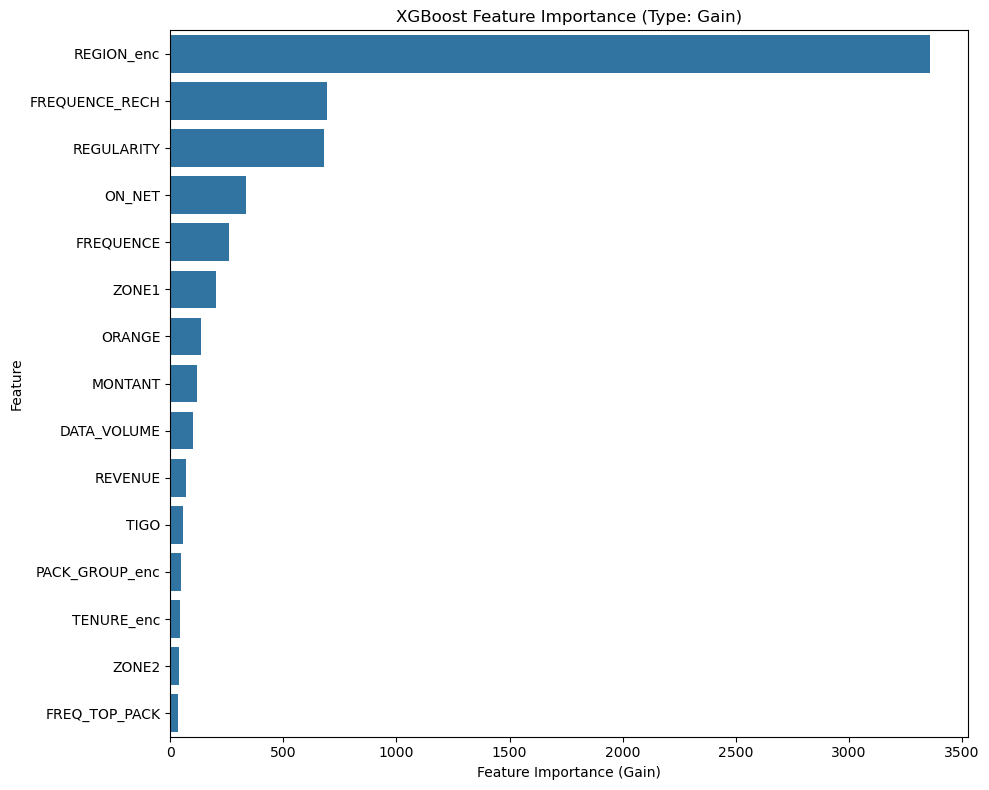

In [2]:
print("\n=== FEATURE IMPORTANCE ===")

# Get feature importances
feature_importances = xgb_model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame for easier plotting
importance_df = pd.DataFrame(
    list(feature_importances.items()), columns=['Feature', 'Importance']
)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('XGBoost Feature Importance (Type: Gain)')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()